In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
import wandb
import torch
wandb.login()

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

torch.manual_seed(42)
np.random.seed(42)

wandb: Currently logged in as: e1527193 (flower-classification). Use `wandb login --relogin` to force relogin


# Download Metrics from WandB

In [3]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("flower-classification/pytorch-sweeps-demo")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("hyp-metrics.csv")

# Transform Metrics

The column `summary` contains most of the metrics we are interested in (`test/precision`,…) but all of the metrics are in a dictionary in this column.

In [4]:
df = pd.read_csv('hyp-metrics.csv',
                 delimiter=',')
df['summary'] = df['summary'].map(eval)
df['config'] = df['config'].map(eval)
df = df.join(pd.json_normalize(df['summary'])).drop('summary', axis='columns')
df = df.join(pd.json_normalize(df['config'])).drop('config', axis='columns')
df

,Unnamed: 0,name,_step,_timestamp,test/recall,test/f1-score,test/epoch_acc,test/epoch_loss,train/epoch_loss,epoch,...,test/batch_loss,eps,gamma,epochs,beta_one,beta_two,optimizer,step_size,batch_size,learning_rate
0,0,fiery-sweep-26,2059,1.680693e+09,0.617021,0.707317,0.733333,0.566462,0.424106,9,...,NaN,1.000000e-01,0.1,10,0.99,0.900,adam,3,4,0.0003
1,1,radiant-sweep-25,1039,1.680693e+09,0.822222,0.747475,0.722222,0.645458,0.64979,9,...,NaN,1.000000e+00,0.5,10,0.99,0.900,adam,2,8,0.0003
2,2,blooming-sweep-24,1039,1.680692e+09,0.783784,0.852941,0.888889,0.348129,0.016143,9,...,NaN,1.000000e-08,0.5,10,0.90,0.999,sgd,5,8,0.0030
3,3,visionary-sweep-23,529,1.680692e+09,0.833333,0.795455,0.800000,0.555318,0.532423,9,...,NaN,1.000000e+00,0.1,10,0.90,0.900,sgd,2,16,0.0003
4,4,ancient-sweep-22,410,1.680692e+09,0.884615,0.707692,0.577778,1.560271,0.75081,1,...,NaN,1.000000e-08,0.5,10,0.90,0.990,adam,7,4,0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,133,different-sweep-5,1159,1.678732e+09,0.714286,0.813953,0.822222,0.493642,0.518635,9,...,0.506896,NaN,0.5,10,NaN,NaN,sgd,3,8,0.0001
134,134,wise-sweep-4,1159,1.678731e+09,0.846154,0.835443,0.855556,0.548264,0.54292,9,...,0.515937,NaN,0.5,10,NaN,NaN,sgd,2,8,0.0001
135,135,misty-sweep-3,2289,1.678731e+09,0.775000,0.849315,0.877778,0.241948,0.020604,9,...,1.758836,NaN,0.5,10,NaN,NaN,sgd,3,4,0.0030
136,136,unique-sweep-2,1159,1.678730e+09,0.684211,0.753623,0.811111,0.479234,0.42905,9,...,0.455120,NaN,0.1,10,NaN,NaN,sgd,3,8,0.0003


In [5]:
df['learning_rate'].value_counts().sort_values(0)


/run/user/1000/ipykernel_39845/2346208349.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  df['learning_rate'].value_counts().sort_values(0)


0.0100    21
0.1000    21
0.0003    23
0.0010    23
0.0001    23
0.0030    27
Name: learning_rate, dtype: int64

In [21]:
# Style the plots (with grid this time)
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 16,
                  'font.size': 16, 'legend.fontsize': 11,
                  'xtick.labelsize': 12, 'ytick.labelsize': 12})

fig_save_dir = '../../thesis/graphics/'

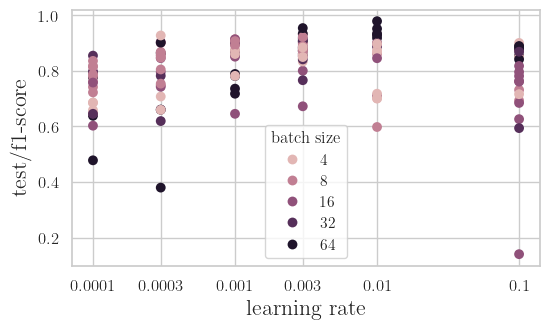

In [22]:
df_prepared = df.rename(columns={'learning_rate': 'learning rate', 'batch_size': 'batch size'})
fig, ax = plt.subplots(1, 1, figsize=set_size(width, subplots=(1,1)))
sns.scatterplot(x="learning rate", y="test/f1-score", hue="batch size",
                palette=sns.cubehelix_palette(5, light=0.8, gamma=1.2),
                sizes=(5, 30), linewidth=0, s=50,
                data=df_prepared, ax=ax)
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1])
ax.set_xticklabels(labels = ['0.0001', '0.0003', '0.001', '0.003', '0.01', '0.1'])
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-hyp-metrics.pdf', format='pdf', bbox_inches='tight')

In [7]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
}

parameters_dict.update({
    'batch_size': {
        'values': [4, 8, 16, 32, 64]},
    'learning_rate': {
        'values': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1]},
    'step_size': {
        'values': [2, 3, 5, 7]},
    'gamma': {
        'values': [0.1, 0.5]},
    'beta_one': {
        'values': [0.9, 0.99]},
    'beta_two': {
        'values': [0.5, 0.9, 0.99, 0.999]},
    'eps': {
        'values': [1e-08, 0.1, 1]}
})

In [8]:
params = pd.DataFrame.from_dict(parameters_dict)
params = params.transpose()
params['values_string'] = [', '.join(map(str, l)) for l in params['values']]
params['values'] = params['values_string']
params = params.drop(['values_string'], axis=1)

In [9]:
params

,values
optimizer,"adam, sgd"
batch_size,"4, 8, 16, 32, 64"
learning_rate,"0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1"
step_size,"2, 3, 5, 7"
gamma,"0.1, 0.5"
beta_one,"0.9, 0.99"
beta_two,"0.5, 0.9, 0.99, 0.999"
eps,"1e-08, 0.1, 1"


In [10]:
pd.DataFrame.from_dict(parameters_dict).explode('optimizer').explode('batch_size').explode('learning_rate').explode('step_size').explode('gamma').explode('beta_one').explode('beta_two').explode('eps')

,optimizer,batch_size,learning_rate,step_size,gamma,beta_one,beta_two,eps
values,adam,4,0.0001,2,0.1,0.9,0.5,0.0
values,adam,4,0.0001,2,0.1,0.9,0.5,0.1
values,adam,4,0.0001,2,0.1,0.9,0.5,1
values,adam,4,0.0001,2,0.1,0.9,0.9,0.0
values,adam,4,0.0001,2,0.1,0.9,0.9,0.1
...,...,...,...,...,...,...,...,...
values,sgd,64,0.1,7,0.5,0.99,0.99,0.1
values,sgd,64,0.1,7,0.5,0.99,0.99,1
values,sgd,64,0.1,7,0.5,0.99,0.999,0.0
values,sgd,64,0.1,7,0.5,0.99,0.999,0.1


# F1-score stratified 10-fold cross validation

In [23]:
f_scores_test = pd.read_csv('f1-scores-folds.csv', delimiter=',')
f_scores_test['epoch'] = np.resize(np.arange(25), 10*25)
f_scores_test['fold'] = np.repeat(np.arange(10), 25)
f_scores_test = pd.melt(f_scores_test[['epoch', 'fold', 'StratifiedKFold-ROC - test/f1-score']], ['epoch', 'fold'])

f_scores_train = pd.read_csv('f1-scores-folds-train.csv', delimiter=',')
f_scores_train['epoch'] = np.resize(np.arange(25), 10*25)
f_scores_train['fold'] = np.repeat(np.arange(10), 25)
f_scores_train = pd.melt(f_scores_train[['epoch', 'fold', 'StratifiedKFold-ROC - train/f1-score']], ['epoch', 'fold'])

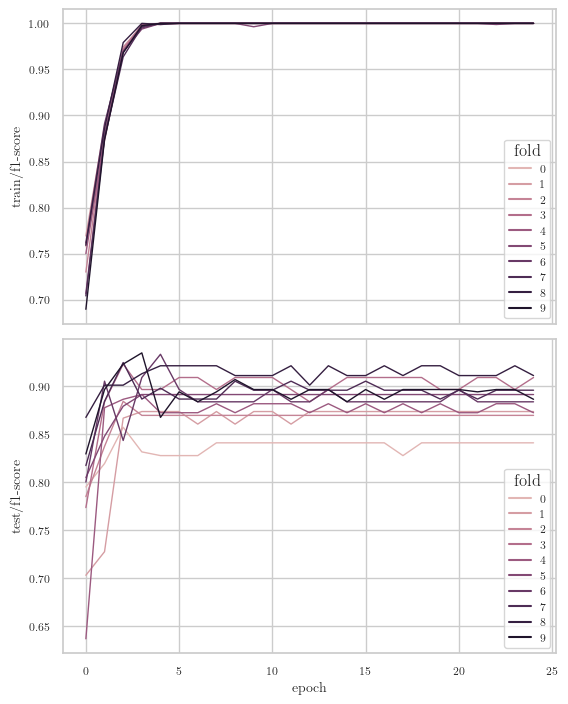

In [66]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, subplots=(2,1)), sharex=True)
sns.lineplot(x="epoch", y="value",
                hue='fold',
                palette=sns.cubehelix_palette(10, light=0.8, gamma=1.2),
                linewidth=1,
                data=f_scores_train, ax=ax[0])

sns.lineplot(x="epoch", y="value",
                hue='fold',
                palette=sns.cubehelix_palette(10, light=0.8, gamma=1.2),
                linewidth=1,
                data=f_scores_test, ax=ax[1])
ax[0].set_ylabel('train/f1-score')
ax[1].set_ylabel('test/f1-score')
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-hyp-folds-f1.pdf', format='pdf', bbox_inches='tight')